<a href="https://colab.research.google.com/github/christianhechmann-econ2021/MastersThesis/blob/main/Reinforcement_Learning_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro - Portfolio/Asset Allocation using Deep Reinforcement Learning

See blog post: https://towardsdatascience.com/



finrl-for-quantitative-finance-tutorial-for-portfolio-allocation-9b417660c7cd

Assumptions of the financial setup for Reinforcement Learning: 
- No shorts sales (no weights are negative)
- No risk-free asset (treasurity bill) allocations
- All capital allocated to financial assets (the weights sum to unity) 
- Daily data are applied - daily rebalnce as well

The components of the Reinforcement Learning setup are:
- Actions - The portfolio weights of the individual asset allocations. Must be in [0,1]. A softmax function normalize discrete allocations such the actions weights to sum to unity.
- State - The state should reflect the financial markets environment. The state is currently defined to be the closing prices, a covariance matrix to define the risk as well as the dependencies of the assets, a list of technical indicators obtained from stockstats.
- Reward function(s) - Either the cumulative portfolio value or a (differential) Sharpe Ratio
- Environment: portfolio allocation for cross asset

The code is based on the OpenAI refinforcement package where one has to follow the structure of the code seen below. openAI allows for both importing predefined environments or defining a new environment using own variables/measures:

```
import gym

class some_env(Env):
  def __init__(self, initial_state, done = False):
    self.state = initial_state
    self.action_space = XX 
    self.observation_space = YY
    self.done = done

  def step(self, action):
    # Take some action ...
    # Update the state ...
    # Compute/update the reward ...
    return self.state, self.reward, self.done, info
    
  def render(self):
    pass
  
  def reset(self):
    return self.state = initial_state
```

So far this project tests the algorithms on stock prices obtained from the Yahoo Finance API 'yfinance'. The project aims at testing the algorithms on financial cross asset data and the current stock data is only for temporary use. 


# Install Packages

In [1]:
# Install Yahoo Finance, stockstats and stable_baselines
!pip install yfinance
!pip install stockstats
!pip install stable_baselines3
!pip install git+https://github.com/quantopian/pyfolio

     |████████████████████████████████| 5.5MB 6.5MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=402a6e116a72e7d7cf0bf5035a79e7f6cae9fdecab2b5921117f7f97955d2b74
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 153kB 5.6MB/s 
  Cloning https://github.com/quantopian/pyfolio to /tmp/pip-req-build-v7o4jyv6
  Running command git clone -q https://github.com/quantopian/pyfolio /tmp/pip-req-build-v7o4jyv6
     |████████████████████████████████| 61kB 3.1MB/s 
  Created wheel for pyfolio: filename=pyfolio-0.9.2+75.g4b901f6-cp37-none-any.whl size=75764 sha256=83b26f8d02010f58846086e4345e24ef31aaae69639fc6a068c27e51511e1da3
  Stored in directory: /tmp/pip-ephem-wheel-cache-x7u0jds9/wheels/62/7d/a7/3e462442ba7d6

# Import libraries

In [2]:
# yfinance syntax: https://towardsdatascience.com/best-5-free-stock-market-apis-in-2019-ad91dddec984

import yfinance as yf
import pandas_datareader.data as pdata # Useful for FF data lib or FRED database
import datetime as dt
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use('ggplot')
import stockstats
from stockstats import StockDataFrame as Sdf
import gym
from gym.utils import seeding
from gym import spaces
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
import pyfolio
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3 import A2C
from stable_baselines3 import PPO
from stable_baselines3 import TD3
from stable_baselines3.td3.policies import MlpPolicy
from stable_baselines3 import SAC
from scipy import stats
import pandas_datareader.data as pdata
from stockstats import StockDataFrame as sdf

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


# Class for downloading and preprocessing financial test data

In [13]:

class data_class:
  '''
  Code implemented with inspiration from https://github.com/AI4Finance-LLC/FinRL-Library/blob/master/finrl/preprocessing/preprocessors.py

  Methods:
  -----------

  extract_data()
    Function to extract stock data from Yahoo Finance

  add_technical_indicators()
    Function to add stockstats technical indicators - input must be pandas dataframe with closing prices in column named 'Close'
  
  add_macro_variables()
    Function to add relevant macro variables from the FRED (Federal Reserve) API

  add_covariance_matrix()
    Function to compute and add rolling window covaraince matrix for trading assets - used as state information in RL algorithms  
  '''

  def __init__(self):
    self = self 
    self.indicator_list = None
    self.data = None
    self. macro_indicator_list = None
    self.start_date = None
    self.end_date = None
    self.tickers = None
    self.horisontal = False

  def extract_data(self, start_date, end_date, tickers, horisontal=False):
    self.start_date = start_date
    self.end_date = end_date
    self.tickers = tickers
    self.horisontal = horisontal

    # List for storing the dataframes
    data = []
    # Loop trhough the different tickers
    for ticker in self.tickers:
      temp = yf.download(ticker, self.start_date, self.end_date)
      temp = pd.DataFrame(temp)
      temp['tic'] = str(ticker) 
      data.append(temp)
      temp = None    

    # Merge the data
    df = pd.concat(data, axis=0)
    df.reset_index(level=0, inplace=True)
    # Make sure the date column has the datatime format 
    df['Date'] =df.Date.apply(lambda x: x.strftime("%Y-%m-%d"))
    # Sort dates 
    df = df.sort_values(['Date', 'tic'], ignore_index=True)
    # Rename 'Adj Close' to 'Close' and drop the Adj Close column (as the adj close represents a total return price index)
    df['Close'] = df['Adj Close']
    df.drop('Adj Close', axis = 1, inplace=True)

    # Ad feature to collect tics in different columns
    if horisontal:
      df = df.pivot_table(index = 'Date', columns='tic', values = 'Close')
      #pd.MultiIndex.from_product([[str(ticker)], temp.columns])
    
    return df

  def add_technical_indicators(self, data, indicator_list):
    self.indicator_list = indicator_list
    self.data = data
    df = self.data.copy()

    # Change the dataframe to stockstats dataframe
    df_sdf = sdf.retype(df.copy())
    # Extract tickers
    tickers = df_sdf.tic.unique()

    for indicator in self.indicator_list:
      # Create empty dataframe for storing temp indicator computations
      df_indicator = pd.DataFrame()

      for i in range(len(tickers)):
        try:
          indicator_temp = df_sdf[df_sdf.tic == tickers[i]][indicator] # Compute indicator
          indicator_temp = pd.DataFrame(indicator_temp) # Transform back to normal pandas dataframe
          df_indicator = df_indicator.append(indicator_temp, ignore_index = True)

        except Exception as e:
          print(e)
      
      # Add the indicator to the original dataframe
      df[indicator] = df_indicator

    # Handle missing values - 
    df = df.fillna(method='bfill').fillna(method='ffill')

    return df

  def add_macro_variables(self, data, macro_indicator_list):
    pass

  def add_covariance_matrix(self, data):
    self.data = data
    df = self.data.copy()

    # Empty list for storing data
    cov_variance = []
    # Factorize index - same dates get the same index number
    df.index = df.Date.factorize()[0]
    # Compute the covariances on a rolling window basis
    window = 252 # One year in trading days
    
    for index_number in range(window, len(df.Date.unique())):
      data_temp = df.loc[index_number - window : index_number, :]
      data_temp_return = data_temp.pivot_table(index = 'Date', columns='tic', values = 'Close').pct_change().dropna()
      data_temp_cov = data_temp_return.cov().values
      cov_variance.append(data_temp_cov)

    # Merge dataframe and covariance dictionary on dates
    df = df.merge(pd.DataFrame({'Date': df.Date.unique()[window:], 'Cov':cov_variance}), on= 'Date')

    # Return Dataframe
    return df

# Downloading and transforming the data

In [14]:
## Define the tickers, technical indicator list and start/ending dates:
tickers = ['AAPL', 'MSFT', 'JNJ', 'JPM']
indicator_list = ["macd","boll_ub","boll_lb", "dx_30","close_30_sma","close_60_sma", 'atr', 'dma', 'pdi', 'mdi', "rsi_30", "cci_30"] # Random technical indicators
start_date = dt.datetime(2010,1,1)
end_date = dt.datetime(2021,1,1)

## Extract the data, 
data_class = data_class()
df = data_class.extract_data(start_date, end_date, tickers)
df = data_class.add_technical_indicators(df, indicator_list) # Imported from http://pypi.org/project/stockstats
df = data_class.add_covariance_matrix(df)

# Visualize the dataframe
df.head(10)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Volume,tic,macd,boll_ub,boll_lb,dx_30,close_30_sma,close_60_sma,atr,dma,pdi,mdi,rsi_30,cci_30,Cov
0,2011-01-03,11.630000,11.795000,11.601429,10.138556,445138400,AAPL,0.085367,18.244424,17.199695,20.117934,17.595178,16.987691,2.296304,0.517938,2.112079,6.270915,52.835949,-69.941831,"[[0.0002849612700238019, 6.568987906250562e-05..."
1,2011-01-03,62.630001,63.180000,62.529999,46.553337,14894800,JNJ,0.045325,18.263107,17.117445,20.117934,17.615222,17.015923,2.288924,0.482231,1.836370,5.452317,51.623772,-81.826620,"[[0.0002849612700238019, 6.568987906250562e-05..."
2,2011-01-03,43.000000,44.040001,42.959999,32.950935,43278500,JPM,0.022116,18.230838,17.076633,20.117934,17.640314,17.044298,2.289890,0.384427,1.590849,4.723347,52.612568,-86.803300,"[[0.0002849612700238019, 6.568987906250562e-05..."
3,2011-01-03,28.049999,28.180000,27.920000,22.194935,53443800,MSFT,-0.013933,18.217102,16.998008,24.218206,17.653868,17.067290,2.286332,0.279138,1.380882,4.795594,50.448000,-119.475912,"[[0.0002849612700238019, 6.568987906250562e-05..."
4,2011-01-04,11.872857,11.875000,11.719643,10.191467,309080800,AAPL,-0.051105,18.224842,16.899848,29.152909,17.653380,17.086992,2.283340,0.168382,1.198332,5.045877,49.364193,-159.482159,"[[0.00028500606043446345, 6.579515104072632e-0..."
5,2011-01-04,63.130001,63.349998,62.750000,46.946095,12346300,JNJ,-0.072564,18.210782,16.834972,25.646226,17.642531,17.106892,2.293035,0.082048,1.387202,4.354604,50.226250,-146.110015,"[[0.00028500606043446345, 6.579515104072632e-0..."
6,2011-01-04,43.779999,44.299999,43.340000,33.427811,40036800,JPM,-0.061495,18.198362,16.821812,17.183485,17.632265,17.130657,2.306488,0.039177,2.068543,3.751979,53.364397,-82.343987,"[[0.00028500606043446345, 6.579515104072632e-0..."
7,2011-01-04,27.940001,28.170000,27.850000,22.282196,54405600,MSFT,-0.024280,18.197833,16.821896,4.672502,17.638766,17.157926,2.329116,0.001858,4.529277,3.220123,56.297670,11.754520,"[[0.00028500606043446345, 6.579515104072632e-0..."
8,2011-01-05,11.769643,11.940714,11.767857,10.274836,255519600,AAPL,-0.002738,18.195672,16.821702,4.672502,17.625965,17.176971,2.316653,-0.014023,3.946493,2.805788,55.278032,-1.483079,"[[0.00028389653581222375, 6.634577033226213e-0..."
9,2011-01-05,63.410000,63.540001,62.950001,46.916451,11837900,JNJ,-0.020297,18.193074,16.792167,11.771805,17.600163,17.189600,2.299952,-0.026634,3.445129,4.888308,51.097471,-69.924431,"[[0.00028389653581222375, 6.634577033226213e-0..."


## Creating a RL environment

In the following we'll code up an RL experiment where the dynamic asset allocation process is modelled as a Markov Decision Process (MDP) problem.

The environment is based on the OpenAI Gym framework. We consider a continuous action space (in order to have a continous weight allocation of the capital). We normalize it to [-1,1] as the policy is defined on a Gaussian distribution. \\

First, we split the data in a training and trade dataset.

In [15]:
# -----------------------------
## Spliting the data into a train and test set
# -----------------------------

df_split = df.copy()
df_split['Date'] =df_split.Date.apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d')) # Needs to be run

# Split the data
train = df_split[df_split['Date']<= dt.datetime(2016,1,1)]
trade = df_split[df_split['Date']> dt.datetime(2016,1,1)]

# Sort the dataframes:
train = train.sort_values(['Date', 'tic'], ignore_index = True)
trade = trade.sort_values(['Date', 'tic'], ignore_index = True)

# Correct the index using factorize 
train.index = train.Date.factorize()[0]
trade.index = trade.Date.factorize()[0]

# See the train dataframe
train.head(10)

,Date,Open,High,Low,Close,Volume,tic,macd,boll_ub,boll_lb,dx_30,close_30_sma,close_60_sma,atr,dma,pdi,mdi,rsi_30,cci_30,Cov
0,2011-01-03,11.630000,11.795000,11.601429,10.138556,445138400,AAPL,0.085367,18.244424,17.199695,20.117934,17.595178,16.987691,2.296304,0.517938,2.112079,6.270915,52.835949,-69.941831,"[[0.0002849612700238019, 6.568987906250562e-05..."
0,2011-01-03,62.630001,63.180000,62.529999,46.553337,14894800,JNJ,0.045325,18.263107,17.117445,20.117934,17.615222,17.015923,2.288924,0.482231,1.836370,5.452317,51.623772,-81.826620,"[[0.0002849612700238019, 6.568987906250562e-05..."
0,2011-01-03,43.000000,44.040001,42.959999,32.950935,43278500,JPM,0.022116,18.230838,17.076633,20.117934,17.640314,17.044298,2.289890,0.384427,1.590849,4.723347,52.612568,-86.803300,"[[0.0002849612700238019, 6.568987906250562e-05..."
0,2011-01-03,28.049999,28.180000,27.920000,22.194935,53443800,MSFT,-0.013933,18.217102,16.998008,24.218206,17.653868,17.067290,2.286332,0.279138,1.380882,4.795594,50.448000,-119.475912,"[[0.0002849612700238019, 6.568987906250562e-05..."
1,2011-01-04,11.872857,11.875000,11.719643,10.191467,309080800,AAPL,-0.051105,18.224842,16.899848,29.152909,17.653380,17.086992,2.283340,0.168382,1.198332,5.045877,49.364193,-159.482159,"[[0.00028500606043446345, 6.579515104072632e-0..."
1,2011-01-04,63.130001,63.349998,62.750000,46.946095,12346300,JNJ,-0.072564,18.210782,16.834972,25.646226,17.642531,17.106892,2.293035,0.082048,1.387202,4.354604,50.226250,-146.110015,"[[0.00028500606043446345, 6.579515104072632e-0..."
1,2011-01-04,43.779999,44.299999,43.340000,33.427811,40036800,JPM,-0.061495,18.198362,16.821812,17.183485,17.632265,17.130657,2.306488,0.039177,2.068543,3.751979,53.364397,-82.343987,"[[0.00028500606043446345, 6.579515104072632e-0..."
1,2011-01-04,27.940001,28.170000,27.850000,22.282196,54405600,MSFT,-0.024280,18.197833,16.821896,4.672502,17.638766,17.157926,2.329116,0.001858,4.529277,3.220123,56.297670,11.754520,"[[0.00028500606043446345, 6.579515104072632e-0..."
2,2011-01-05,11.769643,11.940714,11.767857,10.274836,255519600,AAPL,-0.002738,18.195672,16.821702,4.672502,17.625965,17.176971,2.316653,-0.014023,3.946493,2.805788,55.278032,-1.483079,"[[0.00028389653581222375, 6.634577033226213e-0..."
2,2011-01-05,63.410000,63.540001,62.950001,46.916451,11837900,JNJ,-0.020297,18.193074,16.792167,11.771805,17.600163,17.189600,2.299952,-0.026634,3.445129,4.888308,51.097471,-69.924431,"[[0.00028389653581222375, 6.634577033226213e-0..."


### Code up the Environment

In [52]:
# https://gym.openai.com/

class asset_allocation_environment(gym.Env):
  """Application of OpenAI gym environment for asset allocation
  
  -----------
  Attributes:
  -----------
  df : DataFrame (input data)
  asset_dimension : int (number unique assets for trading)
  max_assets : int (maximum assets that can be traded)
  initial_capital : int (Initial capital base provided for the trading strategy)
  transactions_costs : float (transaction costs in percentage per trade)
  reward_scaling : float (scaling factor for reward - applied especially during training) - suggested to be included in the AI4FINANCE project
  state_space : int (Dimension of input features)
  action_space = int (Number of actions that can be made - must be the same as the asset dimension)
  indicator_list : list (list of the financial indicators applied from the stockstats library)
  time: int (A integer number to control the date/time of the dynamic evolution of the environment)
  
  ------------------
  Methods:
  ------------------
  step(): 
    Function that for each step ensures the agent will take an action, the reward will be compupted, 
           and the function will return the next observation
  reset(): 
    Function that resets the environment to an initial state and returns an initial
            observation.
  render(): 
    Renders the environment. Cannot be applied in Google Colab - not used
  
  saved_returns(): 
    Function that output the capital value at each time step

  saved_actions(): 
    Function that can output the actions/allocations at each time step

  """

  #¤metadata = {'render.modes': ['human']} 

  def __init__(self, df, asset_dimension,\
               max_assets, initial_capital, transactions_costs,\
               reward_scaling, state_space, action_space, indicator_list,\
               window = 252, time = 0):
    
    # Set the self.-values
    self.time = time
    self.window = window
    self.df = df
    self.asset_dimension = asset_dimension 
    self.max_assets = max_assets
    self.initial_capital = initial_capital
    self.transactions_costs = transactions_costs
    self.reward_scaling = reward_scaling
    self.state_space = state_space
    self.action_space = action_space
    self.indicator_list = indicator_list

    # Normalization of the action space
    self.action_space = spaces.Box(low=0, high = 1, shape = (self.action_space,))
    # The observation space is given by the financial indicators + cov matrices
    self.observation_space = spaces.Box(low = -np.inf, high = np.inf, shape = (self.state_space + len(self.indicator_list), self.state_space))

    # Loading the financial data - the input format of the data is pandas dataframe
    self.data = self.df.loc[self.time, :]
    self.covs = self.data['Cov'].values[0] # as the cov matrix is the same for all assets of the day - select the first
    self.state = np.append(np.array(self.covs), [self.data[i].values.tolist() for i in self.indicator_list], axis = 0)

    # Set terminal to 'False' indicating we are not at terminal state
    self.terminal = False

    # Specify score for current portfolio value
    self.portfolio_value = self.initial_capital

    # Specify memory container for capital/wealth stock for each step
    self.asset_memory = [self.initial_capital]

    # Specify memory container for capital/wealth change for each step
    self.portfolio_return_memory = [0] # As the return is none the first date
    self.actions_memory = [[1/self.asset_dimension] * self.asset_dimension] # First allocation is EW
    self.date_memory = [self.data.Date.unique()[0]]



  def step(self, actions):
    # First we evalutae if the day is a terminal state /day
    self.terminal = self.time >= len(self.df.index.unique())-1 # substract with 1 as we start in index 0


    # If it is a terminal state, then the assets/capital are monitored
    # and the return, risk and sharpe ratio is computed
    # If it is not a terminal state then the return and capital are
    # saved to the memory containers 

    if self.terminal:
      
      # Add code for plotting of the cumulate return graph

      print('-------------------------------------------------------')
      print("Total beginning capital: {}".format(self.asset_memory[0]))
      print("Total ending capital: {}".format(self.portfolio_value))
      print('-------------------------------------------------------')

      daily_return_df = pd.DataFrame(self.portfolio_return_memory)
      daily_return_df.columns = ['daily_return']

      # In order to compute Sharpe Ratio = mean/std.dev., then we need to
      # ensure that std.dev. != 0 before doing the calculation

      if daily_return_df['daily_return'].std() != 0:
        # Assume 252 trading days in a year
        sharpe_ratio = np.sqrt(252) * daily_return_df['daily_return'].mean()/daily_return_df['daily_return'].std()

        # We print the Sharpe Ratio as well
        print('-------------------------------------------------------')
        print("Sharpe Ratio: {}".format(sharpe_ratio))
      print('-------------------------------------------------------')
  
      # Return the RL characteristics of the state
      return self.state, self.reward, self.terminal, {}
    
    # If the date is not a terminal state: 
    else:
      # Compute the weights (actions) using the later defined softmax function summing to unity
      weights = self.softmax_normalization(actions)
      # Store the portfolio weights
      self.actions_memory.append(weights)
      # Save the data of the last day in class variable
      last_day = self.data

      # Consider the next time step.
      # At t-1 we select weights for assets, at time t we 
      # evaluate financial performnace during that 1 day time period
      self.time += 1
      self.data = self.df.loc[self.time, : ]
      self.covs = self.data['Cov'].values[0]
      self.state = np.append(np.array(self.covs), [self.data[i].values.tolist() for i in self.indicator_list], axis = 0)
      # Compute individual asset allocations return: weight_t-1 * return_t
      portfolio_return = sum(((self.data.Close.values / last_day.Close.values)-1)*weights)
      # Compute increase in capital from the portfolio return
      portfolio_update = self.portfolio_value*(1 + portfolio_return) 
      self.portfolio_value = portfolio_update
      # Save the return and portfolio information from the step
      self.portfolio_return_memory.append(portfolio_return)
      self.date_memory.append(self.data.Date.unique()[0])
      self.asset_memory.append(portfolio_update)

      ## Define the reward to be the end-portfolio value
      #self.reward = portfolio_update

      ## -------------------
      # New reward
      daily_return_df = pd.DataFrame(self.portfolio_return_memory)
      daily_return_df.columns = ['daily_return']
      sharpe_ratio = np.sqrt(252) * daily_return_df['daily_return'].mean()/daily_return_df['daily_return'].std()
      self.reward = sharpe_ratio

      ## -------------------

    return self.state, self.reward, self.terminal, {}

  def reset(self):
    # Reset all variables - same values as wihtin __init__(self):
    self.asset_memory = [self.initial_capital]
    self.time = 0
    self.data = self.df.loc[self.time, : ]
    self.covs = self.data['Cov'].values[0]
    self.state = np.append(np.array(self.covs), [self.data[i].values.tolist() for i in self.indicator_list], axis = 0)
    self.portfolio_value = self.initial_capital
    self.terminal = False
    self.portfolio_return_memory = [0]
    self.actions_memory = [[1/self.asset_dimension] * self.asset_dimension]
    self.date_memory = [self.data.Date.unique()[0]]
    return self.state



  def softmax_normalization(self, actions):
    # Function that ensures the actions sum to unity
    p = np.exp(actions)
    n = np.sum(np.exp(actions))
    softmax_vector = p/n
    
    # Return the softmax output
    return softmax_vector

  def saved_returns(self):
    # Function that saves the total asset value for each day in dateframe
    dates = self.date_memory
    total_return_memory = self.portfolio_return_memory
    df_ = pd.DataFrame({'Date' : dates, 'daily_return': total_return_memory})
    return df_ 

  def saved_actions(self):
    # Function that stores the actions
    
    # Dates
    dates = self.date_memory
    df_dates = pd.DataFrame(dates)
    df_dates.columns = ['Date']

    # Actions
    actions_list = self.actions_memory
    df_actions = pd.DataFrame(actions_list)
    df_actions.columns = self.data.tic.values
    df_actions.index = df_dates.Date

    return df_actions

  
  def render(self, mode='human'):
    #return self.state
    pass

  def _seed(self, seed=None):
    # based on gym function : np_random(seed=None) https://github.com/openai/gym/blob/master/gym/utils/seeding.py
    self.np_random, seed = seeding.np_random(seed)
    return [seed]

  def get_sb_env(self):
    e = DummyVecEnv([lambda: self])
    obs = e.reset()
    return e, obs


In [55]:
# Define Agent class 


class Agent:
  '''
  Class for Deep Reinforcement Agent methods for a selected number of 
  RL from the stable-baselines3


  Note that env.get_sb_env() corresponds to 'get stable baselines env' 

  Methods (using the Stable Baselines3 library):
  ------------------
    load_model()
      Function that loads the environment and relevant agent 
    
    train_rl_DDPG()
      Function that runs the RL algorithm on the environment - applied on the train data

      Using the implmentation example of:
      https://stable-baselines3.readthedocs.io/en/master/guide/quickstart.html


  '''

  @staticmethod
  def rl_predeiction(model, env_input):
    _env, obs = env_input.get_sb_env()

    # store the returns and actions
    rets_ = []
    actions_ = []

    #obs = _env.reset()
    _env.reset()
    for i in range(len(env_input.df.index.unique())):
      action, _states = model.predict(obs)
      obs, rewards, dones, info = _env.step(action)
      
      if i == (len(env_input.df.index.unique())-2):
        rets_ = _env.env_method(method_name= "saved_returns")
        actions_ = _env.env_method(method_name= "saved_actions")
      if dones[0]:
        print('Results printed')
        break
    
    return rets_[0], actions_[0]

  def __init__(self,env):
    self.env = env

  def load_model(self, model_name, model_kwargs, policy_kwargs = None, policy = 'MlpPolicy', models =  {"A2C": A2C, "DDPG": DDPG, "TD3": TD3, "SAC": SAC, "PPO": PPO}):
    self.models = models
    self.policy = 'MlpPolicy'
    self.policy_kwargs = policy_kwargs

    # Add noise - see example fromhttps://stable-baselines3.readthedocs.io/en/master/modules/td3.html?highlight=OrnsteinUhlenbeckActionNoise#example
    n_actions = self.env.action_space.shape[-1]
    self.action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions), theta=0.15, dt=0.01, initial_noise=None)

    if model_name in ["DDPG", "TD3", "SAC", "PPO"]:
      model = self.models[model_name](policy = self.policy, env = self.env, action_noise=self.action_noise, tensorboard_log="tensorboard_log/christian" ,verbose = 1, policy_kwargs = self.policy_kwargs, **model_kwargs)
    if model_name in ['A2C']:
      model = self.models[model_name](policy = self.policy, env = self.env, tensorboard_log="tensorboard_log/christian" ,verbose = 1, policy_kwargs = self.policy_kwargs, **model_kwargs)


    # Return the model
    return model

  def train_model(self, model, tb_log_name, total_timesteps):
    model = model.learn(total_timesteps = total_timesteps, tb_log_name = tb_log_name)
    return model


# Performance A2C Agent

In [57]:
# Define dimension and state_space
asset_dimension = train.tic.unique().shape[0]
state_space = asset_dimension

# Define initial arguments for environment class - check indicator_list
kwargs = {'reward_scaling': 1e-1, 'max_assets': 100, 'initial_capital': 100,\
          'transactions_costs': 0.0, 'state_space': state_space, \
          'asset_dimension': asset_dimension,  'indicator_list' : indicator_list, \
          'action_space' : asset_dimension}

# Initialize environment
gym_enviroment_train =  asset_allocation_environment(df = train, **kwargs)
train_env, _ = gym_enviroment_train.get_sb_env()

# Specify the parameters
a2c_params = {"n_steps": 5, "ent_coef": 0.01, "learning_rate": 0.0007}
agent_name = "A2C"

# Initialize
agent = Agent(env = train_env)
model_a2c = agent.load_model(model_name = agent_name, model_kwargs = a2c_params)
train_model_a2c = agent.train_model(model = model_a2c, tb_log_name = agent_name, total_timesteps=100000)

Using cpu device
Logging to tensorboard_log/christian/A2C_1
------------------------------------
| time/                 |          |
|    fps                | 290      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -5.64    |
|    explained_variance | 0.018    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.897    |
|    std                | 0.991    |
|    value_loss         | 0.994    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 283      |
|    iterations         | 200      |
|    time_elapsed       | 3        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -5.66    |
|    explained_variance | -0.002   |
|    learning_rate      | 0.0007   |
|    n_updates 

In [59]:
# ------------------------------
## Preditct on train dataset ##
# ------------------------------
train_gym_pred_a2c = asset_allocation_environment(df = train, **kwargs)
df_daily_return_train_a2c, df_actions_train_a2c = Agent.rl_predeiction(model=train_model_a2c, env_input = train_gym_pred_a2c)

# See allocations over time
print(df_actions_train_a2c)

-------------------------------------------------------
Total beginning capital: 100
Total ending capital: 232.59376232982967
-------------------------------------------------------
-------------------------------------------------------
Sharpe Ratio: 1.1008804853802414
-------------------------------------------------------
Results printed
                AAPL       JNJ       JPM      MSFT
Date                                              
2011-01-03  0.250000  0.250000  0.250000  0.250000
2011-01-04  0.391509  0.202830  0.202830  0.202830
2011-01-05  0.233622  0.441523  0.162427  0.162427
2011-01-06  0.402795  0.300845  0.148180  0.148180
2011-01-07  0.365529  0.365529  0.134471  0.134471
...              ...       ...       ...       ...
2015-12-24  0.365529  0.365529  0.134471  0.134471
2015-12-28  0.359677  0.307769  0.166277  0.166277
2015-12-29  0.365529  0.365529  0.134471  0.134471
2015-12-30  0.219151  0.449860  0.165494  0.165494
2015-12-31  0.200206  0.399381  0.200206  0.2

-------------------------------------------------------
Total beginning capital: 100
Total ending capital: 353.2829758350108
-------------------------------------------------------
-------------------------------------------------------
Sharpe Ratio: 1.2844831409393898
-------------------------------------------------------
Results printed


Start date,2016-01-04
End date,2020-12-31
Total months,59
,Backtest
Annual return,28.739%
Cumulative returns,253.283%
Annual volatility,21.474%
Sharpe ratio,1.28
Calmar ratio,0.90
Stability,0.95
Max drawdown,-31.795%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,31.80,2020-02-06,2020-03-23,2020-06-05,87
1,24.04,2018-10-03,2018-12-24,2019-04-23,145
2,13.34,2020-09-02,2020-10-30,2020-12-15,75
3,11.84,2019-05-03,2019-06-03,2019-09-11,94
4,11.78,2018-01-22,2018-02-08,2018-06-06,98


Stress Events,mean,min,max
New Normal,0.11%,-12.17%,11.30%


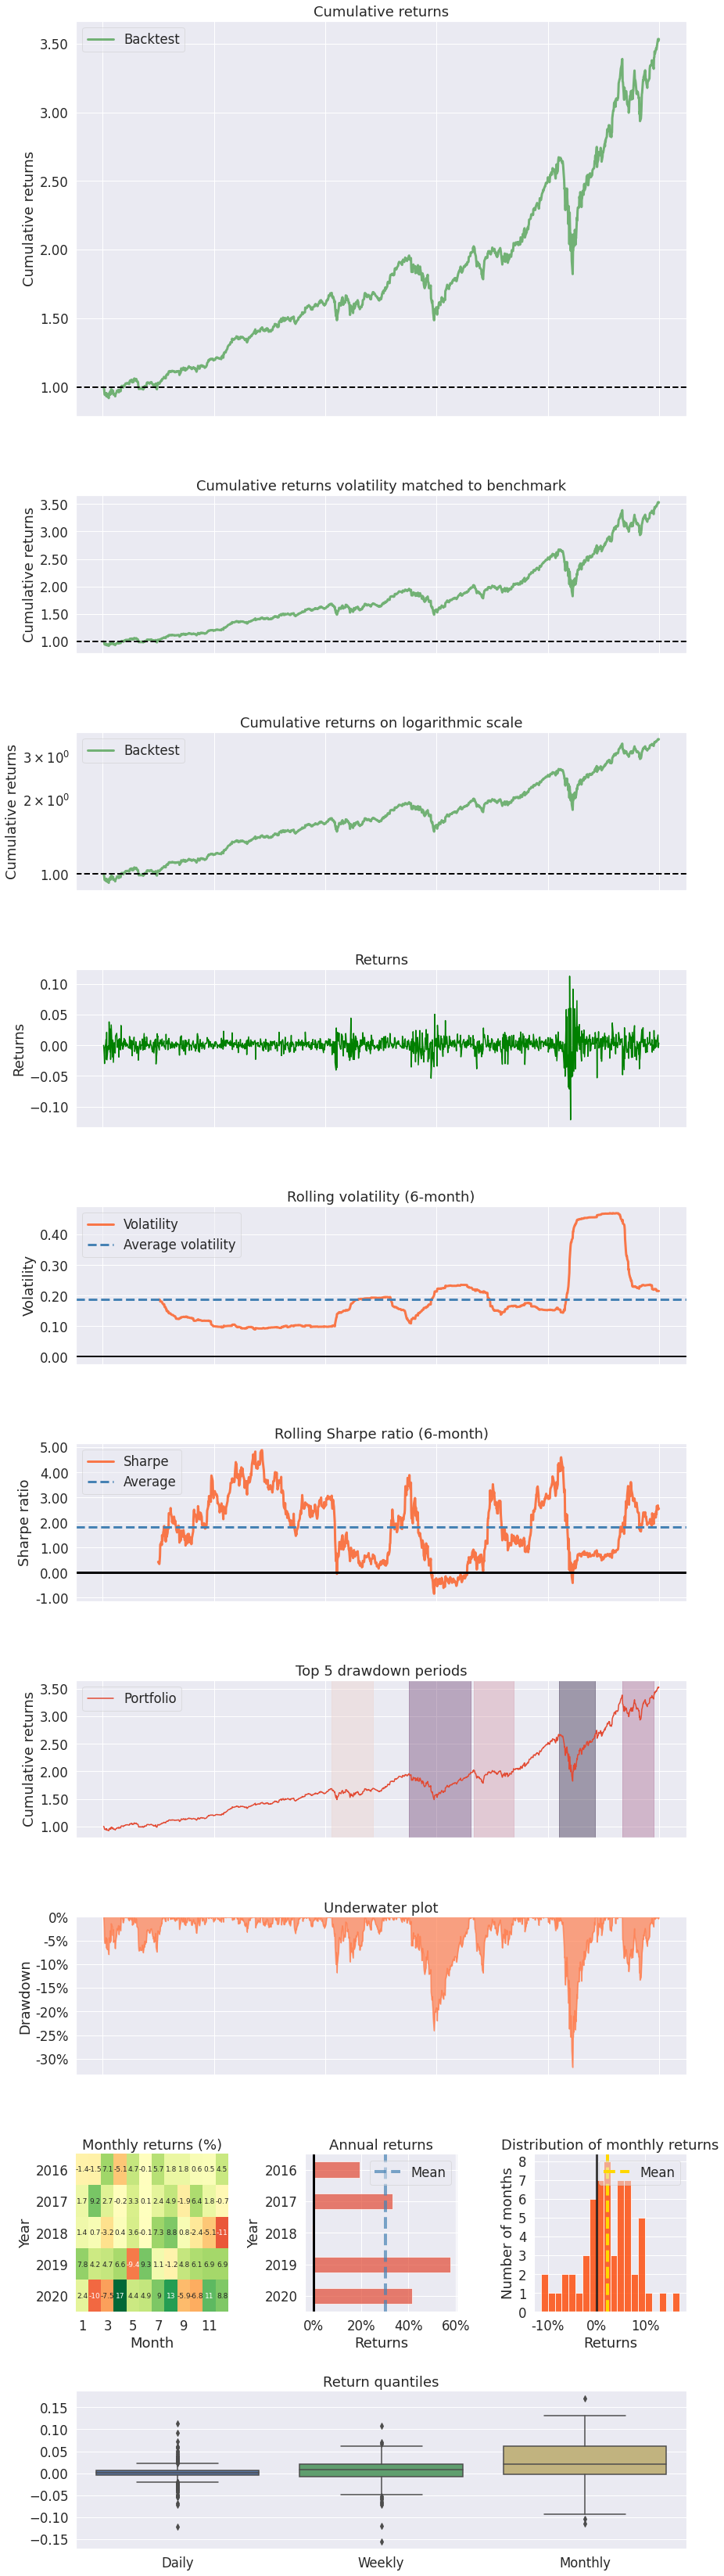

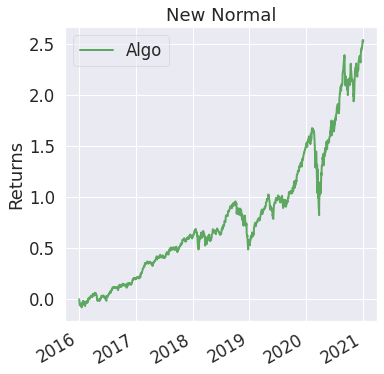

In [60]:
# ------------------------------
## Preditct on trade dataset ##
# ------------------------------
trade_gym_a2c = asset_allocation_environment(df = trade, **kwargs)
df_daily_return_trade_a2c, df_actions_trade_a2c = Agent.rl_predeiction(model=train_model_a2c, env_input = trade_gym_a2c)

## Backtest Results ##
#dir(pyfolio)
backtest_a2c = df_daily_return_trade_a2c['daily_return']
backtest_a2c.index = df_daily_return_trade_a2c['Date']
pyfolio.create_full_tear_sheet(backtest_a2c)

# Performance DDGP Agent

In [46]:
# Define params
ddpg_params = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}

# Define dimension and state_space
asset_dimension = train.tic.unique().shape[0]
state_space = asset_dimension

# Define initial arguments for environment class - check indicator_list
kwargs = {'reward_scaling': 1e-1, 'max_assets': 100, 'initial_capital': 100,\
          'transactions_costs': 0.00, 'state_space': state_space, \
          'asset_dimension': asset_dimension,  'indicator_list' : indicator_list, \
          'action_space' : asset_dimension }

# Initialize environment
gym_enviroment_train =  asset_allocation_environment(df = train, **kwargs)
train_env, _ = gym_enviroment_train.get_sb_env()
#print("The type of the environment is: {}".format(type(train_env)))

# Initialize
agent_name = "DDPG"
agent = Agent(env = train_env)
model_ddpg = agent.load_model(model_name = agent_name, model_kwargs = ddpg_params)
train_model_ddpg = agent.train_model(model = model_ddpg, tb_log_name = agent_name, total_timesteps=100000)

Using cpu device
Logging to tensorboard_log/christian/ddpg_1
-------------------------------------------------------
Total beginning capital: 100
Total ending capital: 203.21302078400367
-------------------------------------------------------
-------------------------------------------------------
Sharpe Ratio: 0.8976947511341772
-------------------------------------------------------
-------------------------------------------------------
Total beginning capital: 100
Total ending capital: 230.178679450139
-------------------------------------------------------
-------------------------------------------------------
Sharpe Ratio: 0.9986176848440554
-------------------------------------------------------
-------------------------------------------------------
Total beginning capital: 100
Total ending capital: 230.178679450139
-------------------------------------------------------
-------------------------------------------------------
Sharpe Ratio: 0.9986176848440554
------------------

KeyboardInterrupt: ignored

In [ ]:
# ----------------------------
## Preditct on trade dataset ##
# ----------------------------
trade_gym_ddpg = asset_allocation_environment(df = trade, **kwargs)
df_daily_return_trade_ddpg, df_actions_trade_ddpg = Agent.rl_predeiction(model=train_model_ddpg, env_input = trade_gym_ddpg)

## Backtest Results ##
backtest_ddpg = df_daily_return_trade_ddpg['daily_return']
backtest_ddpg.index = df_daily_return_trade_ddpg['Date']
pyfolio.create_full_tear_sheet(backtest_ddpg)

-------------------------------------------------------
Total beginning capital: 100
Total ending capital: 116.96957202472022
-------------------------------------------------------
-------------------------------------------------------
Sharpe Ratio: 1.1174510078378914
-------------------------------------------------------
end


# Performance TD3 Agent

In [ ]:
# TD3 agent

td3_params = {"batch_size": 100, "buffer_size": 1000000, "learning_rate": 0.001}

# Define dimension and state_space
asset_dimension = train.tic.unique().shape[0]
state_space = asset_dimension
print('asset_dimension: {}, state space: {}'.format(asset_dimension, state_space))

# Define initial arguments for environment class - check indicator_list
kwargs = {'reward_scaling': 1e-1, 'max_assets': 100, 'initial_capital': 100,\
          'transactions_costs': 0.00, 'state_space': state_space, \
          'asset_dimension': asset_dimension,  'indicator_list' : indicator_list, \
          'action_space' : asset_dimension}

# Initialize environment
gym_enviroment_train =  asset_allocation_environment(df = train, **kwargs)
train_env, _ = gym_enviroment_train.get_sb_env()
print("The type of the environment is: {}".format(type(train_env)))


# Initialize
agent_name = "TD3"
agent = Agent(env = train_env)
model_td3 = agent.load_model(model_name = agent_name, model_kwargs = td3_params)
train_model_td3 = agent.train_model(model = model_td3, tb_log_name = agent_name, total_timesteps=100000)

asset_dimension: 4, state space: 4
The type of the environment is: <class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>
Using cpu device
Logging to tensorboard_log/a2c/a2c/td3_2
-------------------------------------------------------
Total beginning capital: 100
Total ending capital: 358.755311071471
-------------------------------------------------------
-------------------------------------------------------
Sharpe Ratio: 1.226984940024841
-------------------------------------------------------
-------------------------------------------------------
Total beginning capital: 100
Total ending capital: 349.8213223531466
-------------------------------------------------------
-------------------------------------------------------
Sharpe Ratio: 1.1170785454476486
-------------------------------------------------------
-------------------------------------------------------
Total beginning capital: 100
Total ending capital: 355.5523533349131
-------------------------------

In [ ]:
## Predict on trade dataset ##
trade_gym_td3 = asset_allocation_environment(df = trade, **kwargs)
df_daily_return_td3_trade, df_actions_tde_trade = Agent.rl_predeiction(model=train_model_td3, env_input = trade_gym_td3)

## Backtest
backtest_td3 = df_daily_return_td3_trade['daily_return']
backtest_td3.index = df_daily_return_td3_trade['Date']
pyfolio.create_full_tear_sheet(backtest_td3)

-------------------------------------------------------
Total beginning capital: 100
Total ending capital: 198.90289362192306
-------------------------------------------------------
-------------------------------------------------------
Sharpe Ratio: 0.9708513252622861
-------------------------------------------------------
end


# Performance SAC Agent

In [56]:
# TD3 agent

sac_params = {"batch_size": 64, "buffer_size": 100000, "learning_rate": 0.0001, "learning_starts": 100, "batch_size": 64, "ent_coef": "auto_0.1"}

# Define dimension and state_space
asset_dimension = train.tic.unique().shape[0]
state_space = asset_dimension

# Define initial arguments for environment class - check indicator_list
kwargs = {'reward_scaling': 1e-1, 'max_assets': 100, 'initial_capital': 100,\
          'transactions_costs': 0.00, 'state_space': state_space, \
          'asset_dimension': asset_dimension,  'indicator_list' : indicator_list, \
          'action_space' : asset_dimension}

# Initialize environment
gym_enviroment_train =  asset_allocation_environment(df = train, **kwargs)
train_env, _ = gym_enviroment_train.get_sb_env()
print("The type of the environment is: {}".format(type(train_env)))


# Initialize
agent_name = "SAC"
agent = Agent(env = train_env)
model_sac = agent.load_model(model_name = agent_name, model_kwargs = sac_params)
train_model_sac = agent.train_model(model = model_sac, tb_log_name = agent_name, total_timesteps=100000)

The type of the environment is: <class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>
Using cpu device
Logging to tensorboard_log/christian/SAC_1
-------------------------------------------------------
Total beginning capital: 100
Total ending capital: 209.78163601061576
-------------------------------------------------------
-------------------------------------------------------
Sharpe Ratio: 0.9383540051872168
-------------------------------------------------------
-------------------------------------------------------
Total beginning capital: 100
Total ending capital: 208.8751284507026
-------------------------------------------------------
-------------------------------------------------------
Sharpe Ratio: 0.9340754289094784
-------------------------------------------------------
-------------------------------------------------------
Total beginning capital: 100
Total ending capital: 218.63729373911494
-------------------------------------------------------
----

KeyboardInterrupt: ignored

In [ ]:
## Predict on trade dataset ##
trade_gym_sac = asset_allocation_environment(df = trade, **kwargs)
df_daily_return_sac_trade, df_actions_tde_trade = Agent.rl_predeiction(model=train_model_sac, env_input = trade_gym_sac)

## Backtest
backtest_sac = df_daily_return_sac_trade['daily_return']
backtest_sac.index = df_daily_return_sac_trade['Date']
pyfolio.create_full_tear_sheet(backtest_sac)

# Performance PPO Agent

In [ ]:
## Define parameters
ppo_params = {"n_steps": 2048, "ent_coef": 0.01, "learning_rate": 0.00025, "batch_size": 64}

# Define dimension and state_space
asset_dimension = train.tic.unique().shape[0]
state_space = asset_dimension
#print('asset_dimension: {}, state space: {}'.format(asset_dimension, state_space))

# Define initial arguments for environment class - check indicator_list
kwargs = {'reward_scaling': 1e-1, 'max_assets': 100, 'initial_capital': 100,\
          'transactions_costs': 0.00, 'state_space': state_space, \
          'asset_dimension': asset_dimension,  'indicator_list' : indicator_list, \
          'action_space' : asset_dimension}

# Initialize environment
gym_enviroment_train =  asset_allocation_environment(df = train, **kwargs)
train_env, _ = gym_enviroment_train.get_sb_env()
print("The type of the environment is: {}".format(type(train_env)))


# Initialize
agent_name = "PPO"
agent = Agent(env = train_env)
model_ppo = agent.load_model(model_name = agent_name, model_kwargs = ppo_params)
train_model_ppo = agent.train_model(model = model_ppo, tb_log_name = agent_name, total_timesteps=100000)

In [ ]:
## Predict on trade dataset ##
trade_gym_ppo = asset_allocation_environment(df = trade, **kwargs)
df_daily_return_ppo_trade, df_actions_tde_trade = Agent.rl_predeiction(model=train_model_ppo, env_input = trade_gym_ppo)

## Backtest
backtest_ppo = df_daily_return_ppo_trade['daily_return']
backtest_ppo.index = df_daily_return_ppo_trade['Date']
pyfolio.create_full_tear_sheet(backtest_ppo)

# Performance of Equally Weighted (EW) portfolio in trading data

EW portfolio:
Beginning capital: 100.0, Ending Capital: 338.13125545483024
Sharpe ratio: 1.231488190006839


Start date,2016-01-05
End date,2020-12-31
Total months,59
,Backtest
Annual return,27.64%
Cumulative returns,238.131%
Annual volatility,21.757%
Sharpe ratio,1.23
Calmar ratio,0.87
Stability,0.96
Max drawdown,-31.638%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,31.64,2020-02-10,2020-03-23,2020-07-14,112
1,21.43,2018-10-03,2018-12-24,2019-04-22,144
2,11.64,2020-09-02,2020-09-23,2020-11-16,54
3,9.97,2018-01-22,2018-02-08,2018-03-09,35
4,9.96,2019-05-03,2019-06-03,2019-07-02,43


Stress Events,mean,min,max
New Normal,0.11%,-11.98%,12.82%


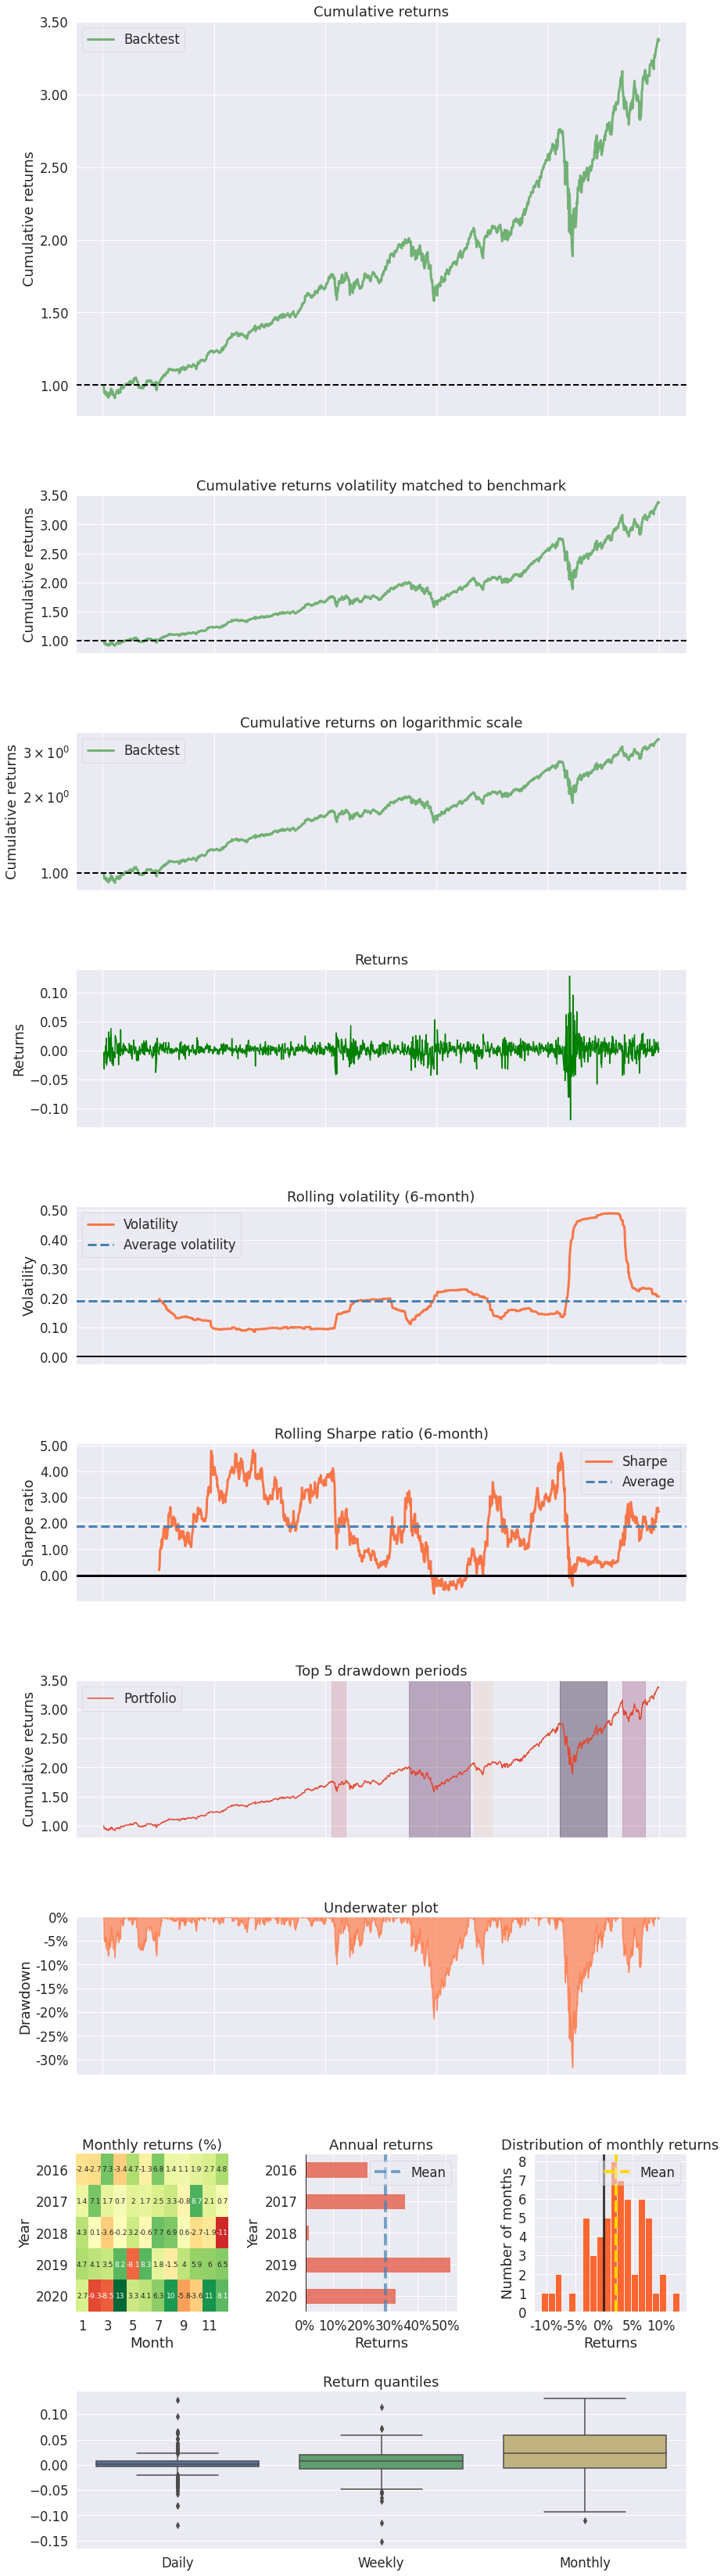

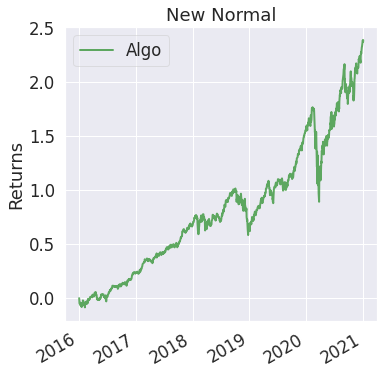

In [45]:
# Define again the tickers and weights
tickers = ['AAPL', 'MSFT', 'JNJ', 'JPM']
weights_ = [1/len(tickers) for i in tickers]

stock_return_data_list = []

for ticker in tickers:
  temp_df = trade[trade.tic == ticker].Close.pct_change()
  stock_return_data_list.append(temp_df)

## Merge the dataframes
df_merge_trade = pd.concat(stock_return_data_list, axis=1)
df_merge_trade.columns = tickers

## Store returns and cumulative returns in lists
returns = []
returns_for_cumprod = [100]

## Loop through all days and skip the first day as it is contains NAN
for i in range(1, len(df_merge_trade)):
  temp_ret = df_merge_trade.iloc[i,:].values * weights_
  temp_ret = sum(temp_ret)
  returns.append(temp_ret)
  returns_for_cumprod.append(1+temp_ret)

cumulative_ret = np.array(returns_for_cumprod).cumprod()

## Print the performance
print("EW portfolio:")
print("Beginning capital: {}, Ending Capital: {}".format(cumulative_ret[0], cumulative_ret[-1]))
print("Sharpe ratio: {}".format(np.sqrt(252) * np.mean(returns)/np.std(returns)))

## Show backtest results using pyfolio
backtest_ew = pd.Series(returns)
backtest_ew.index = trade.Date.unique()[1:]
pyfolio.create_full_tear_sheet(backtest_ew)

# Economic Macro Data Overview


In [ ]:
'''
Growth:
GDP - Gross Domestic Product
GDPC1 - Real Gross Domestic Product
GDPPOT - Real Potential Gross Domestic Product

Inflation:
CPIAUCSL - Consumer Price Index for All Urban Consumers: All Items
CPILFESL- Consumer Price Index for All Urban Consumers: All Items Less Food & Energy
GDPDEF - Gross Domestic Product: Implicit Price Deflator\n",

Money Supply:
BASE - St. Louis Adjusted Monetary Base
M1 - M1 Money Stock
M2 - M2 Money Stock
M1V - Velocity of M1 Money Stock
M2V - Velocity of M2 Money Stock

Interest Rates:
DFF - Effective Federal Funds Rate
DTB3 - 3-Month Treasury Bill: Secondary Market Rate
DGS5 - 5-Year Treasury Constant Maturity Rate
DGS10 - 10-Year Treasury Constant Maturity Rate
DGS30 - 30-Year Treasury Constant Maturity Rate
T5YIE - 5-year Breakeven Inflation Rate
T10YIE - 10-year Breakeven Inflation Rate
T5YIFR - 5-Year, 5-Year Forward Inflation Expectation Rate
TEDRATE - TED Spread
DPRIME - Bank Prime Loan Rate

Employment:
UNRATE - Civilian Unemployment Rate
NROU - Natural Rate of Unemployment (Long-Term)
NROUST - Natural Rate of Unemployment (Short-Term)
CIVPART - Civilian Labor Force Participation Rate
EMRATIO - Civilian Employment-Population Ratio
UNEMPLOY - Unemployed
PAYEMS - All Employees: Total nonfarm
MANEMP - All Employees: Manufacturing
ICSA - Initial Claims
IC4WSA - 4-Week Moving Average of Initial Claims

Income and expenditure:
MEHOINUSA672N - Real Median Household Income in the United States
DSPIC96 - Real Disposable Personal Income
PCE - Personal Consumption Expenditures
PCEDG - Personal Consumption Expenditures: Durable Goods
PSAVERT - Personal Saving Rate
RRSFS - Real Retail and Food Services Sales
DSPI - Disposable personal income

Other Economic Indicators:
INDPRO - Industrial Production Index
TCU - Capacity Utilization: Total Industry
HOUST - Housing Starts: Total: New Privately Owned Housing Units Started
GPDI - Gross Private Domestic Investment
CP - Corporate Profits After Tax (without IVA and CCAdj)
STLFSI - St. Louis Fed Financial Stress Index
DCOILWTICO - Crude Oil Prices: West Texas Intermediate (WTI) - Cushing, Oklahoma
USSLIND - Leading Index for the United States
DTWEXM - Trade Weighted U.S. Dollar Index: Major Currencies
DTWEXB - Trade Weighted U.S. Dollar Index: Broad
VIXCLS - Market expectation of near term volatility conveyed by stock index option prices

Debt:
GFDEBTN - Federal Debt: Total Public Debt
GFDEGDQ188S - Federal Debt: Total Public Debt as Percent of Gross Domestic Product
EXCSRESNW - Excess Reserves of Depository Institutions
TOTCI - Commercial and Industrial Loans, All Commercial Banks

New indicators:
USALORSGPNOSTSAM - Leading Indicators OECD: Reference series: Gross Domestic Product (GDP): Normalised for the United States
GEPUCURRENT - Global Economic Policy Uncertainty Index: Current Price Adjusted GDP
CHNLORSGPNOSTSAM - Leading Indicators OECD: Reference series: Gross Domestic Product (GDP): Normalised for China

Currency:
DEXUSEU - USDEUR exchange rate

'''



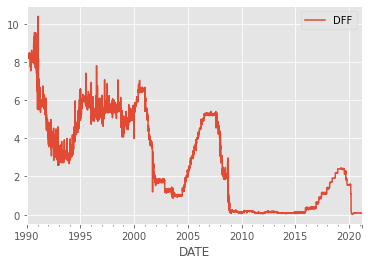

In [50]:
## Some lists with variables
growth = ['GDP', 'GDPC1', 'GDPPOT']
inflation = ['CPIAUCSL', 'CPILFESL', 'GDPDEF']
money_supply = ['BASE', 'M1', 'M2', 'M1V', 'M2V']
interest_rates = ['DFF', 'DTB3', 'DGS5', 'DGS10', 'DGS30', 'T5YIE', 'T10YIE', 'T5YIFR', 'TEDRATE', 'DPRIME' ]
employment = ['UNRATE', 'NROU', 'NROUST', 'CIVPART', 'EMRATIO', 'UNEMPLOY', 'PAYEMS', 'MANEMP', 'ICSA', 'IC4WSA']
income_expend = ['MEHOINUSA672N', 'DSPIC96', 'PCE', 'PCEDG', 'PSAVERT', 'RRSFS', 'DSPI']
other_indicators = ['INDPRO', 'TCU', 'HOUST', 'GPDI', 'CP', 'STLFSI', 'DCOILWTICO', 'USSLIND', 'DTWEXM', 'DTWEXB']
debt = ['GFDEBTN', 'GFDEGDQ188S', 'EXCSRESNW', 'TOTCI']

# Define dates
start = dt.datetime(1990,1,1)
end = dt.datetime(2021,3,10)

# Some example 
name = interest_rates[0]
econ_df = pdata.DataReader(name= name, data_source = 'fred', start = start, end = end)
econ_df = econ_df.iloc[::-1]
econ_df.plot()